In [1]:
import numpy as np
import json
import operator
import os

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
#201758
#ROOT_DIR = os.path.dirname(os.path.abspath(__file__))  # This is your Project Root
ROOT_DIR = os.getcwd()

def load_gold():
    fe_all_filename = os.path.join(ROOT_DIR, "../../data/gold/fatalencs/fe-all.json")
    alldata = [json.loads(line) for line in open(fe_all_filename)]
    testents = set(d['name'] for d in alldata if '2016-09-01' <= d['date'] <= '2016-12-31')
    histents= set(d['name'] for d in alldata if d['date'] < '2016-09-01')
    all = testents.union(histents)
    #print all.pop()
    return all

#load_gold()
def load_dictionary():
    #print os.getcwd()
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.getcwd()
    corpus_file_json = open(dir_path + "/../../data/json_corpus/all.json")
    sentence_ids_file_json = open(dir_path + "/../../data/query_configurations/sentence_ids.json")
    sentence_id_data = json.load(sentence_ids_file_json)
    #print sentence_id_data.keys()
    #print corpus_file_json
    doc_id_set = set()
    id_dict = {}
    train_id_dict = {}
    line_id = 0
    for line in corpus_file_json:
        data = json.loads(line)
        doc_id_set.add(data['docid'])
        id_dict.setdefault(data['docid'], [])
        id_dict[data['docid']].append(data['name'])
        if str(line_id) in sentence_id_data.keys():
            #print "worked"
            train_id_dict.setdefault(data['name'], 1)
        line_id +=1
    #print train_id_dict
    #print id_dict
    #print 'doc _id_set' + str(len(doc_id_set))
    return id_dict, train_id_dict

#1 Q0 1498571_322_0 1 -6.30739 IR
def get_metric_values(file, chunk_size, id_dict, name_set, train_id_dictionary):
    name_dict = {}
    for i in np.arange(chunk_size):
        line = file.readline()
        #print line
        line_splitted = line.split()
        name_list = id_dict[line_splitted[2].strip()]
        #print i
        for name in name_list:
            if name in name_dict:
                name_dict[name] = name_dict[name] + 1
            else:
                name_dict[name] = 1
    sorted_data = sorted(name_dict.items(), key=operator.itemgetter(1), reverse=True)
    #print sorted_data[0:100]
    precs=[]
    recs=[]
    set_of_retrieved_names = set()
    tp = 0.0
    fp = 0.0
    fn = 0.0
    for e,p in sorted_data:
        #rank_incl_hist += 1
        #name_set contains the gold data
        if e in name_set and e not in train_id_dictionary:
            #print 'matched'
            set_of_retrieved_names.add(e)
            #rank += 1
            #if e in ts:
            tp += 1
            fn -= 1
        else:
            fp += 1
        precs.append(tp/(tp+fp))
        recs.append(1)
    #print 'precs 50 ' + str(precs[10])
    #print precs[20]
    #print len(set_of_retrieved_names)
    return precs[5], precs[10], precs[20], float(len(set_of_retrieved_names)), set_of_retrieved_names


import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [2]:
id_dictionary, train_id_dictionary = load_dictionary()
name_set = load_gold()
#print 'printing name set'
#print len(name_set)
number_of_examples = 20
methods = ["SearchIE", "PRF", "QL", "Weak-LR"]
method_marker = ["v", "s", "+", "x"]
method_color = ["red", "magenta", "blue", "green"]


p_30 = np.zeros((len(methods), number_of_examples))
p_50 = np.zeros((len(methods), number_of_examples))
p_100 = np.zeros((len(methods), number_of_examples))
civilians_found = np.zeros((len(methods), number_of_examples))
number_of_simulations = 50
all_results_p_30 = np.zeros((len(methods) * number_of_simulations, number_of_examples))
all_results_p_50 = np.zeros((len(methods) * number_of_simulations, number_of_examples))
all_results_p_100 = np.zeros((len(methods) * number_of_simulations, number_of_examples))
all_results_civilians_found = np.zeros((len(methods) * number_of_simulations, number_of_examples))

files = ["iterative_lr_ir_run_dir/", "iterative_prf_run_dir/", "iterative_lm_run_dir/", "iterative_lr_run_dir/clean/"]
for idx, file_method in enumerate(files):
    for i in np.arange(number_of_simulations):
        #print 'at least printing'
        file = open("../../data/runs/" + file_method + str(i + 1) + ".xml.run")
        #file = open("../../data/runs/iterative_prf_run_dir/" + str(i + 2) + ".xml.run")
        #file = open("../../data/runs/iterative_lm_run_dir/" + str(i + 2) + ".xml.run")
        #file = open("../../data/runs/iterative_lr_ir_run_dir/" + str(i + 2) + ".xml.run")

        #file_to_write = open("clean/" + str(i + 1) + ".xml.run", "w")
        #print 'starting with file ' + str(i + 1)
        # 1 Q0 1482418_115_0 3 -6.45492 IR
        p_30_list = []
        p_50_list = []
        p_100_list = []
        civilians_found_list = []
        #print file
        for j in np.arange(number_of_examples):
            #print 'working with query number ' + str(i + 1)
            precs30, precs50, precs100, number_of_civilians_found, name_of_civilians = get_metric_values(file, 1000, id_dictionary, name_set, train_id_dictionary)
            p_30_list.append(precs30)
            p_50_list.append(precs50)
            p_100_list.append(precs100)
            civilians_found_list.append(number_of_civilians_found)
        #print p_30_list
        p_30[idx] += np.asarray(p_30_list)
        p_50[idx] += np.asarray(p_50_list)
        p_100[idx] += np.asarray(p_100_list)
        civilians_found[idx]+=np.asarray(civilians_found_list)
        all_results_p_30 [idx * number_of_simulations + i, :] = np.asarray(p_30_list)
        all_results_p_50[idx * number_of_simulations + i, :] = np.asarray(p_50_list)
        all_results_p_100[idx * number_of_simulations + i, :] = np.asarray(p_100_list)
        all_results_civilians_found[idx * number_of_simulations + i, :] = np.asarray(civilians_found_list)

    p_30[idx] /= number_of_simulations
    p_50[idx] /= number_of_simulations
    p_100[idx] /= number_of_simulations
    civilians_found[idx] /= number_of_simulations

terms = []
for i in np.arange(number_of_examples):
    terms.append(i)

#f, axarr = plt.subplots(2, 2)
#plt.rcParams["figure.figsize"] = 4, 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


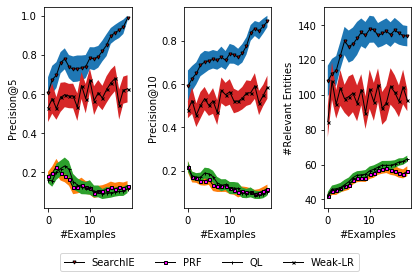

In [4]:
f, axarr = plt.subplots(1, 3)
line_reference = []
for idx, method in enumerate(methods):
    l1 = axarr[0].plot(terms, p_30[idx], marker=method_marker[idx], markerfacecolor=method_color[idx], markersize=3, color='black', linewidth=1,
             label=method, linestyle='-')
    line_reference.append(l1)
    min_err_p_30 = []
    max_err_p_30 = []
    mean = []
    for example in range(number_of_examples):
        #print all_results_p_30[idx * number_of_simulations: idx * number_of_simulations + number_of_simulations, example]
        m, lower, upper = mean_confidence_interval(all_results_p_30[idx * number_of_simulations: idx * number_of_simulations + number_of_simulations , example])
        #print m
        mean.append(m)
        min_err_p_30.append(lower)
        max_err_p_30.append(upper)

    axarr[0].fill_between(terms, np.asarray(min_err_p_30), np.asarray(max_err_p_30))
    #axarr[0].set_title('Precision@5')
    axarr[1].plot(terms, p_50[idx], marker=method_marker[idx], markerfacecolor=method_color[idx], markersize=3, color='black', linewidth=1,
             label=method, linestyle='-')

    min_err_p_50 = []
    max_err_p_50 = []
    mean = []
    for example in range(number_of_examples):
        # print all_results_p_30[idx * number_of_simulations: idx * number_of_simulations + number_of_simulations, example]
        m, lower, upper = mean_confidence_interval(
            all_results_p_50[idx * number_of_simulations: idx * number_of_simulations + number_of_simulations,
            example])
        # print m
        mean.append(m)
        min_err_p_50.append(lower)
        max_err_p_50.append(upper)

    axarr[1].fill_between(terms, np.asarray(min_err_p_50), np.asarray(max_err_p_50))


    #axarr[1].set_title('Precision@10')

    axarr[2].plot(terms, civilians_found[idx], marker=method_marker[idx], markerfacecolor=method_color[idx], markersize=3, color='black', linewidth=1,
                     label=method, linestyle='-')

    min_err_civilians_found = []
    max_err_civilians_found = []
    mean = []
    for example in range(number_of_examples):
        # print all_results_p_30[idx * number_of_simulations: idx * number_of_simulations + number_of_simulations, example]
        m, lower, upper = mean_confidence_interval(
            all_results_civilians_found[idx * number_of_simulations: idx * number_of_simulations + number_of_simulations,
            example])
        # print m
        mean.append(m)
        min_err_civilians_found.append(lower)
        max_err_civilians_found.append(upper)
    axarr[2].fill_between(terms, np.asarray(min_err_civilians_found), np.asarray(max_err_civilians_found))

    #axarr[2].set_title('#Relevant entities')

    #f.text(0.5, 0.005 , 'Number of Examples in Query', ha='center', fontsize=10)

    # p_30_str = '['
    # for i in p_30[idx]:
    #     p_30_str += str(i) + ","
    # print p_30_str + ']'
    #

    p_50_str = ''
    for i in p_50[idx]:
        p_50_str += str(i) + "\t"
    #print p_50_str.strip()

    p_100_str = ''
    for i in p_100[idx]:
        p_100_str += str(i) + "\t"
    #print p_100_str.strip()

    civilians_found_str = ''
    for i in civilians_found[idx]:
        civilians_found_str += str(i) + "\t"
    #print civilians_found_str.strip()
handles, labels = axarr[0].get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),
#               fancybox=True, shadow=True, ncol=5)
#axarr[1].legend(methods, loc="upper left")
#axarr[2].legend(methods, loc="upper left")
plt.subplots_adjust(top=0.90, bottom=0.20, left=0.1, right=0.95, hspace=0.25, wspace=0.6)
f.legend(handles=handles, labels=labels, loc="lower center", borderaxespad=0.1, ncol=4 )
#plt.subplots_adjust(right=0.85)  # adjust the subplot to the right for the legend
#plt.xlabel('xlabel', fontsize=18)
#plt.ylabel('ylabel', fontsize=16)
axarr[0].set_xlabel('#Examples', fontsize=10)
axarr[0].set_ylabel('Precision@5', fontsize=10)

axarr[1].set_xlabel('#Examples', fontsize=10)
axarr[1].set_ylabel('Precision@10', fontsize=10)

axarr[2].set_xlabel('#Examples', fontsize=10)
axarr[2].set_ylabel('#Relevant Entities', fontsize=10)

plt.savefig("example_effect.eps")
plt.show()
